# SSF-MCMC vs QAOA学習データ

すでに行なった実験を設定を修正して再実験。

## import

In [1]:
import numpy as np
import scipy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import font_manager
import time
import IProgress
from tqdm.notebook import tqdm
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from qulacs import QuantumState
from skqulacs.circuit import LearningCircuit
import qulacsvis as qvis

import made
from made import MADE
import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz

plt.rcParams["font.family"] = "Helvetica Neue"
plt.rcParams['mathtext.fontset'] = 'cm'

seed = 1514
rng = np.random.default_rng(seed)

## 1. インスタンス準備

In [2]:
n_spin = 10
instance = Ising_model(n_spin, rng, type='SK')

### 描画

/var/folders/5z/hnd7blsn33vdfn4r3xgj5_sh0000gn/T/ipykernel_17969/3784416733.py:21: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  edges = nx.draw_networkx_edges(G, pos, width=2.0, edge_color=edge_colors, edge_cmap=cmap_J, edge_vmin=-J_range, edge_vmax=J_range, ax=ax0)


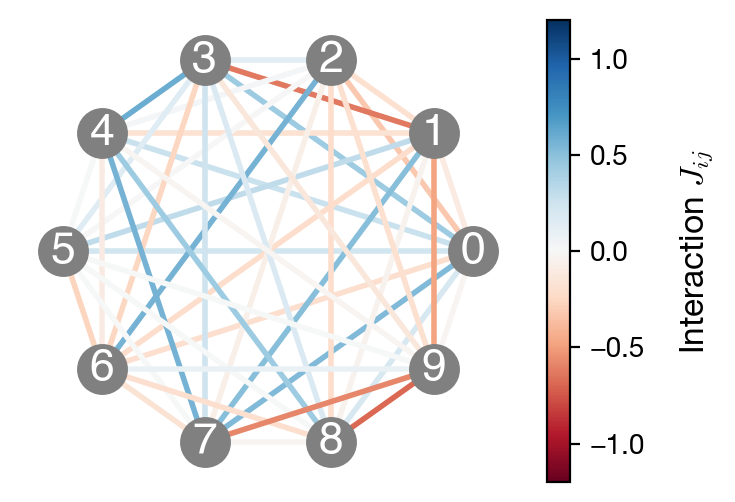

In [3]:
J, index_list, h = instance.get_parameter()

fig0, ax0 = plt.subplots(figsize=(4,3), dpi=200)

# instance graph
ax0.spines["top"].set_linewidth(0)
ax0.spines["left"].set_linewidth(0)
ax0.spines["bottom"].set_linewidth(0)
ax0.spines["right"].set_linewidth(0)

G = nx.Graph()
edge_colors = []
for i,j in index_list:
    G.add_edge(i,j, weight=J[i,j])
    edge_colors.append(J[i,j])

J_range = 1.2
cmap_J = plt.cm.RdBu

pos = nx.circular_layout(G)
edges = nx.draw_networkx_edges(G, pos, width=2.0, edge_color=edge_colors, edge_cmap=cmap_J, edge_vmin=-J_range, edge_vmax=J_range, ax=ax0)
nodes = nx.draw_networkx_nodes(G, pos, node_size=300, node_color='grey', ax=ax0)
nx.draw_networkx_labels(G, pos, font_size=16, font_color="white", font_weight='bold', font_family='Helvetica' , ax=ax0)
sm1 = plt.cm.ScalarMappable(cmap=cmap_J, norm=plt.Normalize(vmin=-J_range, vmax=J_range))

cbar0_1 = fig0.colorbar(sm1, ax=ax0)
cbar0_1.set_label(label=r'Interaction $J_{ij}$', fontsize=12, labelpad=12)

## 2. 教師データ準備

### 設定

In [4]:
# MADE
n_step = n_spin # 間引きの間隔
n_samples = 2 ** n_spin
n_data_list = [10, 25, 50, 100, 2**n_spin]

# spectral gap
beta_list = np.logspace(-2, 2, 41)

### SSF教師データサンプリング

In [5]:
# sampling
mcmc_data = np.zeros([beta_list.shape[0], n_step*n_samples, n_spin])
spin_data = np.zeros([beta_list.shape[0], n_samples, n_spin])
ar_data = np.zeros([beta_list.shape[0], n_step*n_samples-1])

j = 0
for beta in tqdm(beta_list):
	init_spin = mcmc.number_to_spin(rng.integers(0, 2**n_spin), n_spin)
	for i in range(n_step*n_samples):
		# update
		if i == 0:
			mcmc_data[j,0] = mcmc.ssf_update(init_spin, instance, beta, rng)[0]
		else:
			mcmc_data[j,i] = mcmc.ssf_update(mcmc_data[j,i-1], instance, beta, rng)[0]

		# data
		if i % n_step == n_step-1:
			spin_data[j,(i//n_step)] = mcmc_data[j,i]
	
	ssf_data_id = np.array([mcmc.spin_to_number(spin_data[j,k]) for k in range(spin_data.shape[1])])
	ssf_data_nd = np.array([qaoa.number_to_binary(ssf_data_id[k], n_spin) for k in range(ssf_data_id.shape[0])], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！

	if j == 0:
		ssf_data = ssf_data_nd[np.newaxis]
	else:
		ssf_data = np.concatenate([ssf_data, ssf_data_nd[np.newaxis]])
  
	j += 1

  0%|          | 0/41 [00:00<?, ?it/s]

### 確認

In [6]:
print(ssf_data.shape)
print(ssf_data.dtype)


(41, 1024, 10)
float32


### QAOA教師データサンプリング

In [7]:
# setting
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_spin)
n_layers = 5
qaoa_ansatz = QAOA_ansatz(prob_hamiltonian, mixer_hamiltonian, n_layers)

def cost(para):
    return qaoa.cost_QAOA(prob_hamiltonian, qaoa_ansatz, para)

def callback(para):
    para_history.append(para)
    cost_history.append(cost(para))

# running QAOA
#init_para = [rng.uniform(0, 2*np.pi) for i in range(2*n_layers)]
init_para = [0.2705, -0.5899, 0.4803, -0.4492, 0.5074, -0.3559, 0.5646, -0.2643, 0.6397, -0.1291] #文献におけるSKmodelに対するQAOA(p=5)の固定角
para_history = [init_para]
cost_history = [cost(init_para)]

method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-6}
opt = scipy.optimize.minimize(cost, init_para, 
                              method=method,
                              callback=callback,
                              options=options)

opt_para = para_history[-1]

# sampling QAOA outputs
opt_qaoa_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, para_history[-1], n_samples) # optimize parameter
fix_qaoa_data_idx = qaoa.sampling_QAOA(qaoa_ansatz, init_para, n_samples) # fixed angle

opt_qaoa_data_nd = np.array([qaoa.number_to_binary(opt_qaoa_data_idx[i], n_spin) for i in range(len(opt_qaoa_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！
fix_qaoa_data_nd = np.array([qaoa.number_to_binary(fix_qaoa_data_idx[i], n_spin) for i in range(len(fix_qaoa_data_idx))], dtype='float32') # MADEモデルのコードが重み行列をfloat32で記述しているため、データもfloat32に明示的に指定する！

Optimization terminated successfully.
         Current function value: -4.138371
         Iterations: 24
         Function evaluations: 319
         Gradient evaluations: 29


## 3. MADE学習 & spectral gap計算

### 設定

In [8]:
hidden_size = int(2 * n_spin)
hidden_layers = 2
hidden_list = [hidden_size for i in range(hidden_layers)]

batchsize = 8
lr = 0.005
n_epochs = 30

In [9]:
def calc_mh_gap(energy_vector, proposal_mat, beta):
    n_state = energy_vector.shape[0]
    
    P = np.zeros((n_state, n_state))
    A = mcmc.calc_boltzmann_mh_acceptance(energy, proposal_mat, beta)
    P = proposal_mat * A
    np.fill_diagonal(P, 0)
    
    for i in range(2**n_spin):
        P[i,i] = 1 - np.sum(P[:,i])
        
    return mcmc.spectral_gap(P)

def calc_metropolis_gap(energy_vector, proposal_mat, beta):
    n_state = energy_vector.shape[0]
    
    P = np.zeros((n_state, n_state))
    A = mcmc.calc_boltzmann_metropolis_acceptance(energy, beta)
    P = proposal_mat * A
    np.fill_diagonal(P, 0)
    
    for i in range(2**n_spin):
        P[i,i] = 1 - np.sum(P[:,i])
        
    return mcmc.spectral_gap(P)

# prep
ssf_made_pred_list = np.zeros((len(n_data_list), beta_list.shape[0], 2**n_spin))
opt_qaoa_made_pred_list = np.zeros((beta_list.shape[0], 2**n_spin))
fix_qaoa_made_pred_list = np.zeros((beta_list.shape[0], 2**n_spin))

ssf_made_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))
opt_qaoa_made_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))
fix_qaoa_made_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))
uni_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))
ssf_gap_list = np.zeros((len(n_data_list), beta_list.shape[0]))

energy = np.array([ising.spin_energy(ising.number_to_spin(i, n_spin), instance) for i in range(2**n_spin)])
uni_Q = np.ones((2**n_spin, 2**n_spin)) / (2**n_spin) # uniform

ssf_Q = np.zeros((2**n_spin, 2**n_spin)) # single spin-flip
for i in range(2**n_spin):
	spin = mcmc.number_to_spin(i, n_spin)
	for j in range(n_spin):
		flip_spin = mcmc.single_spin_flip(spin, j)
		index = mcmc.spin_to_number(flip_spin)
		ssf_Q[index, i] += 1
for i in range(2**n_spin):
	ssf_Q[:,i] /= np.sum(ssf_Q[:,i])

# main
for j in tqdm(range(len(n_data_list))):
	n_data = n_data_list[j]
	n_train = int(0.8*n_data)
	n_test = n_data - n_train
 
	# train MADE(QAOA)
	opt_qaoa_data_torch = torch.from_numpy(opt_qaoa_data_nd[0:n_data]).to(dtype=torch.float32)
	opt_qaoa_traindata, opt_qaoa_testdata = torch.utils.data.random_split(dataset=opt_qaoa_data_torch, lengths=[n_train, n_test], generator=torch.Generator().manual_seed(seed))
	fix_qaoa_data_torch = torch.from_numpy(fix_qaoa_data_nd[0:n_data]).to(dtype=torch.float32)
	fix_qaoa_traindata, fix_qaoa_testdata = torch.utils.data.random_split(dataset=fix_qaoa_data_torch, lengths=[n_train, n_test], generator=torch.Generator().manual_seed(seed))
 
	model_opt_qaoa = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
	opt_opt_qaoa = torch.optim.Adam(model_opt_qaoa.parameters(), lr=lr, weight_decay=1e-4)
	scheduler_opt_qaoa = torch.optim.lr_scheduler.StepLR(opt_opt_qaoa, step_size=45, gamma=0.1)

	model_fix_qaoa = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
	opt_fix_qaoa = torch.optim.Adam(model_fix_qaoa.parameters(), lr=lr, weight_decay=1e-4)
	scheduler_fix_qaoa = torch.optim.lr_scheduler.StepLR(opt_fix_qaoa, step_size=45, gamma=0.1)

	opt_qaoa_testset = torch.utils.data.DataLoader(opt_qaoa_testdata, batch_size=batchsize, shuffle=False)
	opt_qaoa_trainset = torch.utils.data.DataLoader(opt_qaoa_traindata, batch_size=batchsize, shuffle=True)
	fix_qaoa_testset = torch.utils.data.DataLoader(fix_qaoa_testdata, batch_size=batchsize, shuffle=False)
	fix_qaoa_trainset = torch.utils.data.DataLoader(fix_qaoa_traindata, batch_size=batchsize, shuffle=True)

	made.run_train(model_opt_qaoa, opt_qaoa_trainset, opt_qaoa_testset, n_epochs, opt_opt_qaoa, scheduler_opt_qaoa)
	made.run_train(model_fix_qaoa, fix_qaoa_trainset, fix_qaoa_testset, n_epochs, opt_fix_qaoa ,scheduler_fix_qaoa)

	opt_qaoa_pred_dist = made.sampling_MADE(model_opt_qaoa)
	fix_qaoa_pred_dist = made.sampling_MADE(model_fix_qaoa)

	opt_qaoa_made_pred_list[j] = opt_qaoa_pred_dist
	fix_qaoa_made_pred_list[j] = fix_qaoa_pred_dist
	
	opt_qaoa_made_Q = np.zeros((2**n_spin, 2**n_spin))
	fix_qaoa_made_Q = np.zeros((2**n_spin, 2**n_spin))
	for i in range(2**n_spin):
		opt_qaoa_made_Q[i] = opt_qaoa_pred_dist[i] # MADE(QAOA + opt)
		fix_qaoa_made_Q[i] = fix_qaoa_pred_dist[i] # MADE(QAOA + fixed angle)

	# calculation for each beta
	for i in tqdm(range(len(beta_list)), leave=True):
		beta = beta_list[i]
	
		# train MADE(SSF)
		ssf_data_torch = torch.from_numpy(ssf_data[i,0:n_data]).to(dtype=torch.float32)
		ssf_traindata, ssf_testdata = torch.utils.data.random_split(dataset=ssf_data_torch, lengths=[n_train, n_test], generator=torch.Generator().manual_seed(seed))

		model_ssf = MADE(n_spin, hidden_list, n_spin, num_masks=1, natural_ordering=True)
		opt_ssf = torch.optim.Adam(model_ssf.parameters(), lr=lr, weight_decay=1e-4)
		scheduler_ssf = torch.optim.lr_scheduler.StepLR(opt_ssf, step_size=45, gamma=0.1)

		ssf_testset = torch.utils.data.DataLoader(ssf_testdata, batch_size=batchsize, shuffle=False)
		ssf_trainset = torch.utils.data.DataLoader(ssf_traindata, batch_size=batchsize, shuffle=True)

		made.run_train(model_ssf, ssf_trainset, ssf_testset, n_epochs, opt_ssf, scheduler_ssf)

		ssf_made_pred_dist = made.sampling_MADE(model_ssf)
		ssf_made_pred_list[j,i] = ssf_made_pred_dist
		ssf_made_Q = np.zeros((2**n_spin, 2**n_spin))
		for l in range(2**n_spin):
			ssf_made_Q[l] = ssf_made_pred_dist[l]
	
		# calculate spectral gap
		ssf_made_gap_list[j,i] = calc_mh_gap(energy, ssf_made_Q, beta)
		opt_qaoa_made_gap_list[j,i] = calc_mh_gap(energy, opt_qaoa_made_Q, beta)
		fix_qaoa_made_gap_list[j,i] = calc_mh_gap(energy, fix_qaoa_made_Q, beta)
		uni_gap_list[j,i] = calc_metropolis_gap(energy, uni_Q, beta)
		ssf_gap_list[j,i] = calc_metropolis_gap(energy, ssf_Q, beta)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

/Users/yuichiro_nakano/mydrive/Research/Fujii_Lab/Project/NN_proposal_MCMC_used_QAOA_sample/qaoa-made-mcmc/src/lib/mcmc_function.py:147: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(likelihood)
/Users/yuichiro_nakano/mydrive/Research/Fujii_Lab/Project/NN_proposal_MCMC_used_QAOA_sample/qaoa-made-mcmc/src/lib/mcmc_function.py:162: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(likelihood)


  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

/Users/yuichiro_nakano/mydrive/Research/Fujii_Lab/Project/NN_proposal_MCMC_used_QAOA_sample/qaoa-made-mcmc/src/lib/mcmc_function.py:143: RuntimeWarning: divide by zero encountered in log
  proposal_diff = np.log(reverse_proposal_mat) - np.log(proposal_mat)
/Users/yuichiro_nakano/mydrive/Research/Fujii_Lab/Project/NN_proposal_MCMC_used_QAOA_sample/qaoa-made-mcmc/src/lib/mcmc_function.py:143: RuntimeWarning: invalid value encountered in subtract
  proposal_diff = np.log(reverse_proposal_mat) - np.log(proposal_mat)


### 結果の描画

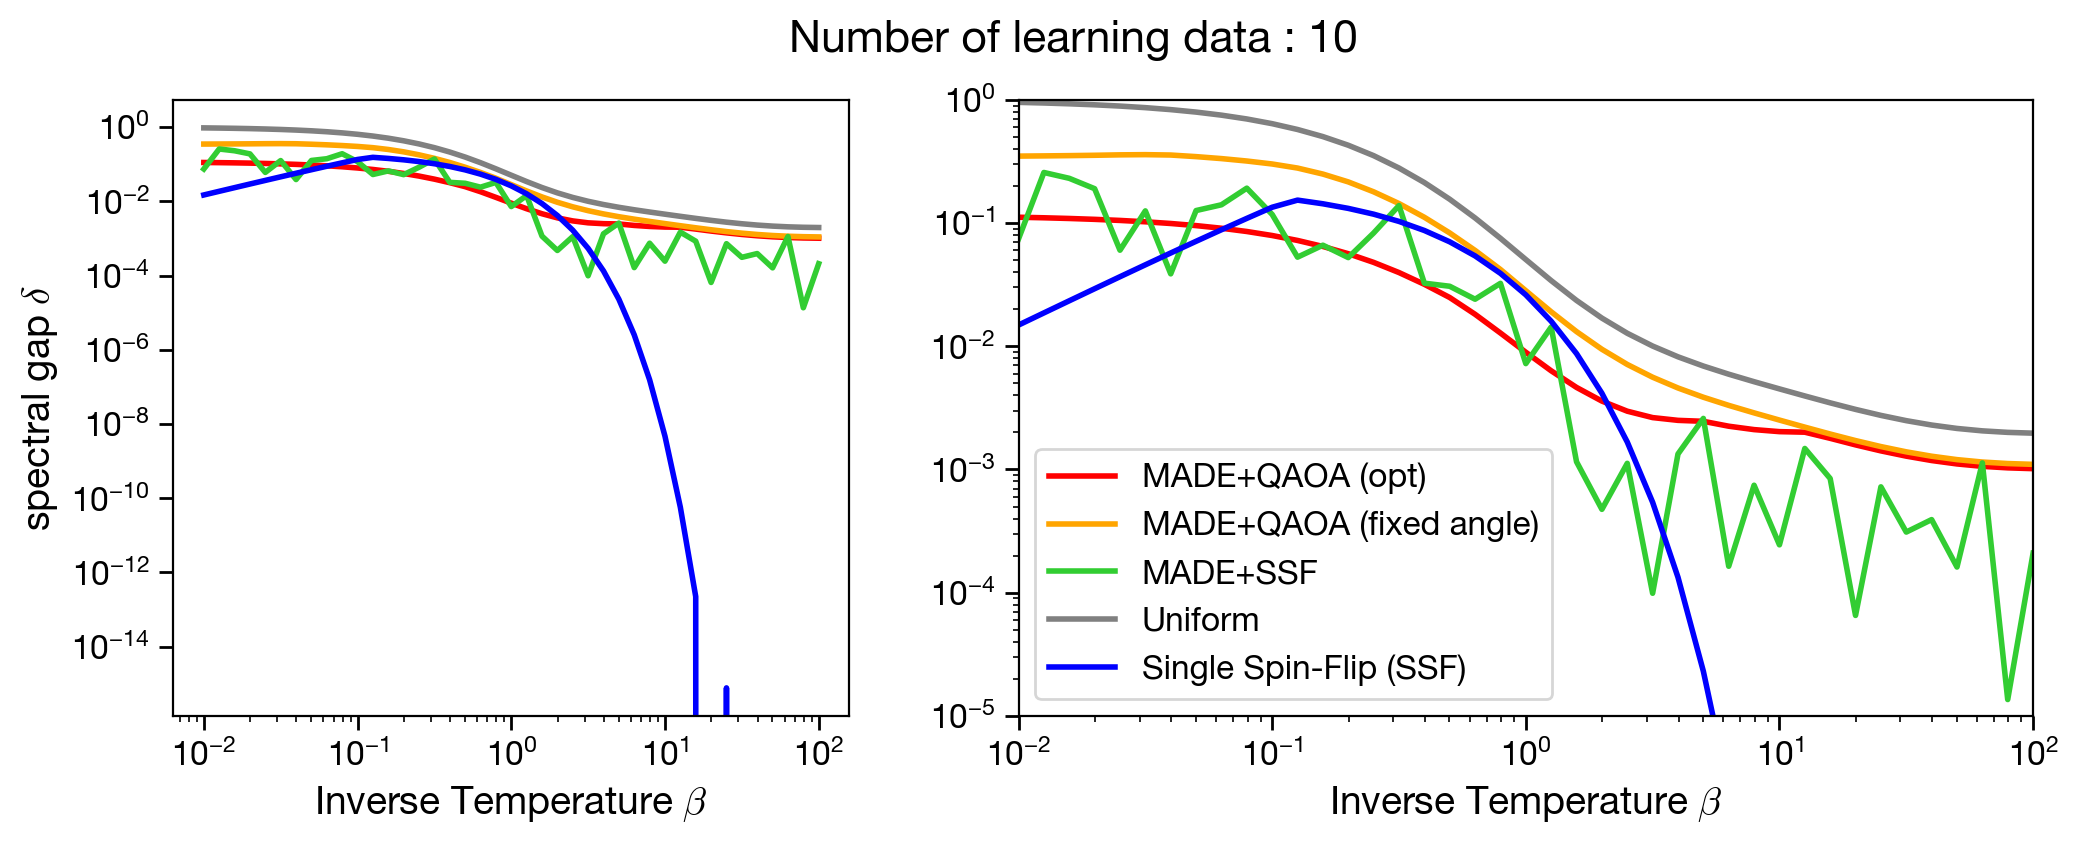

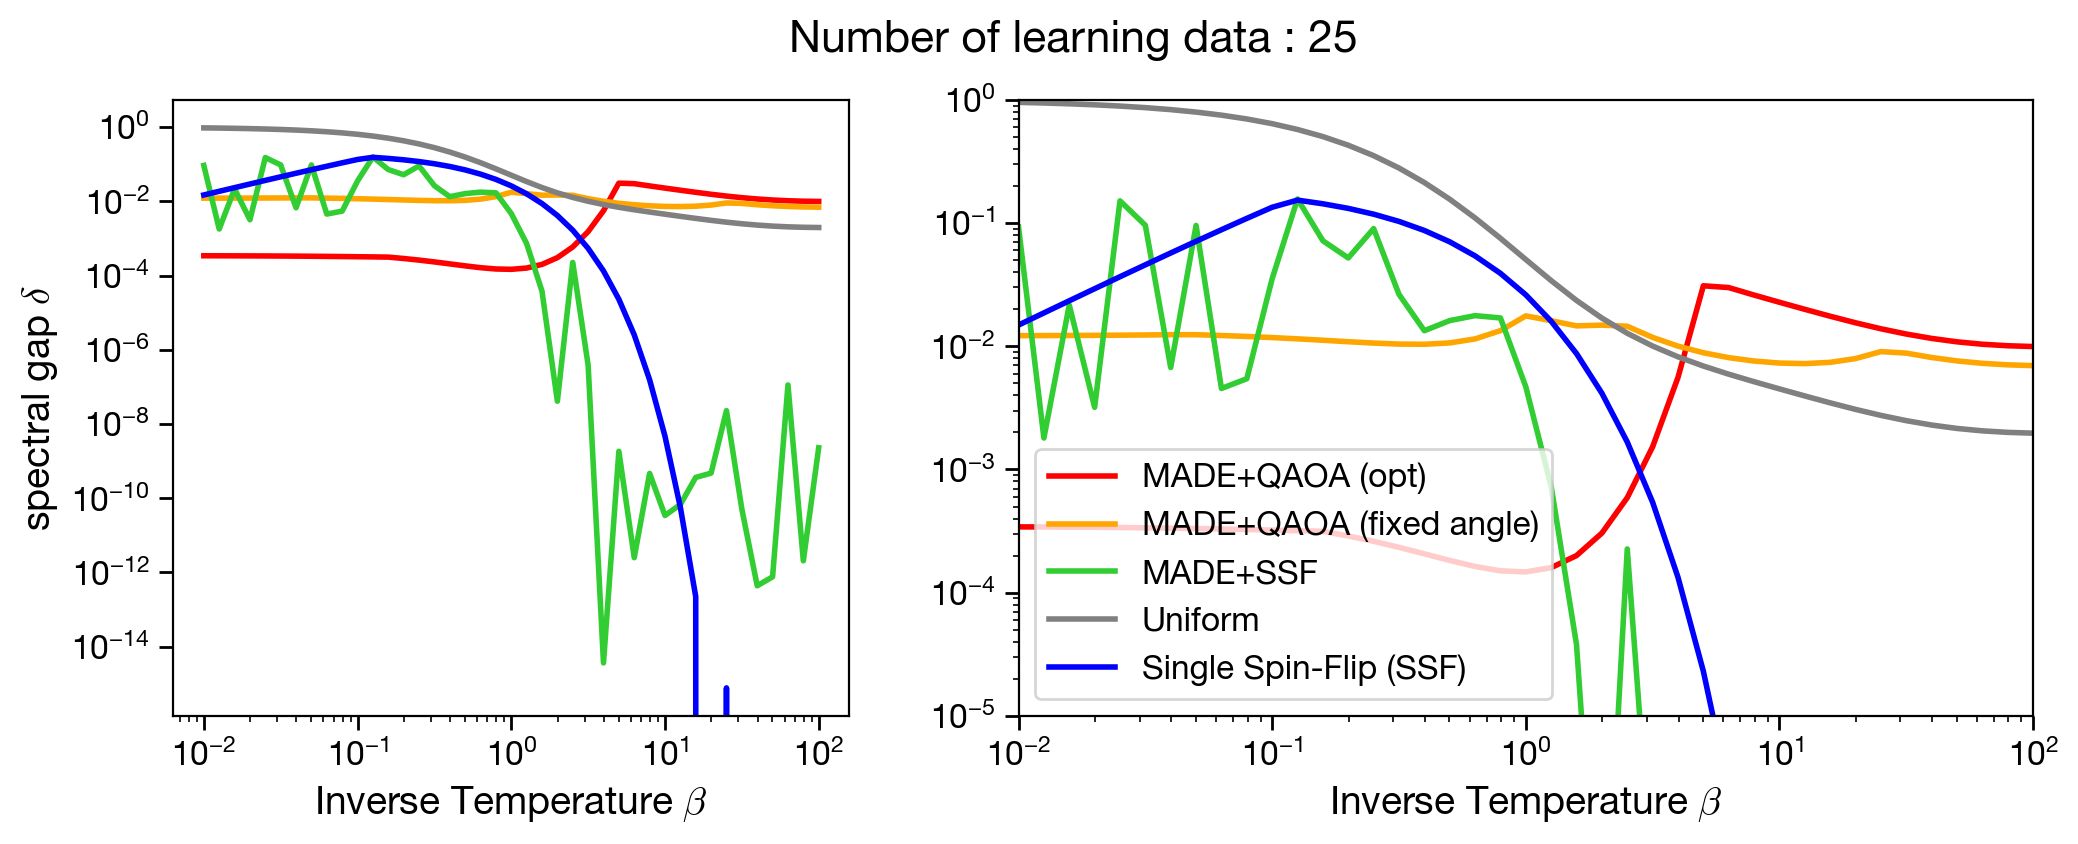

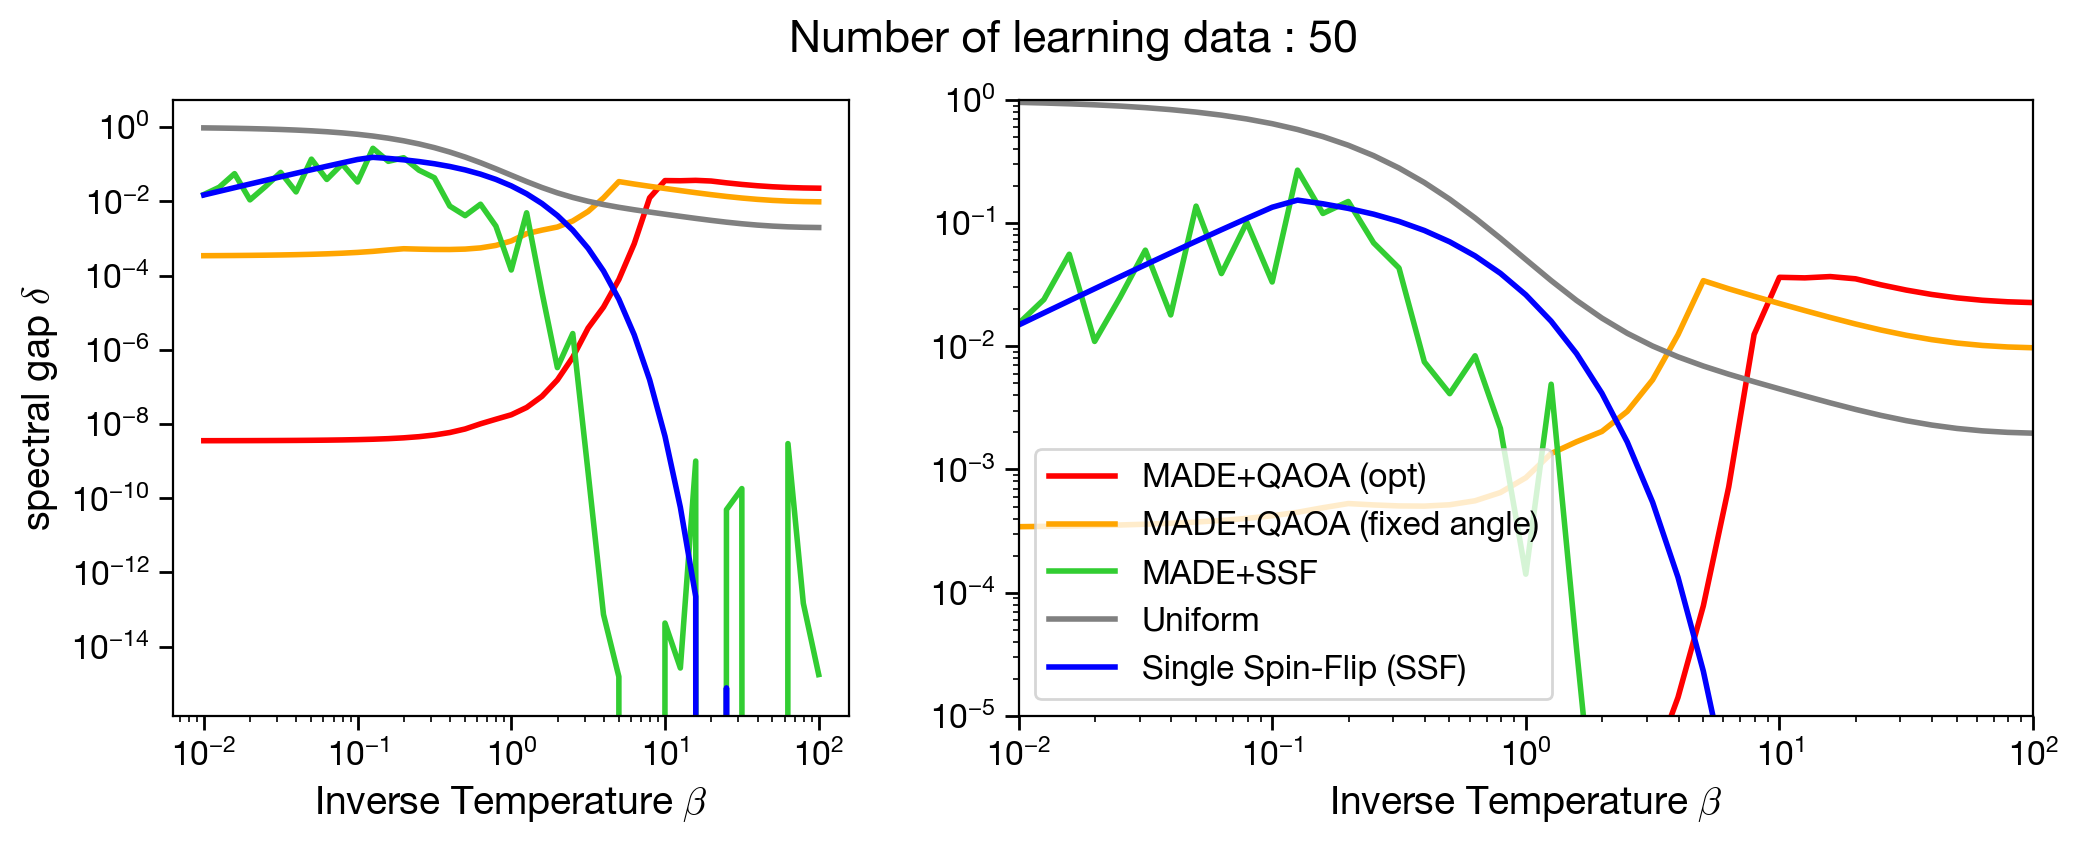

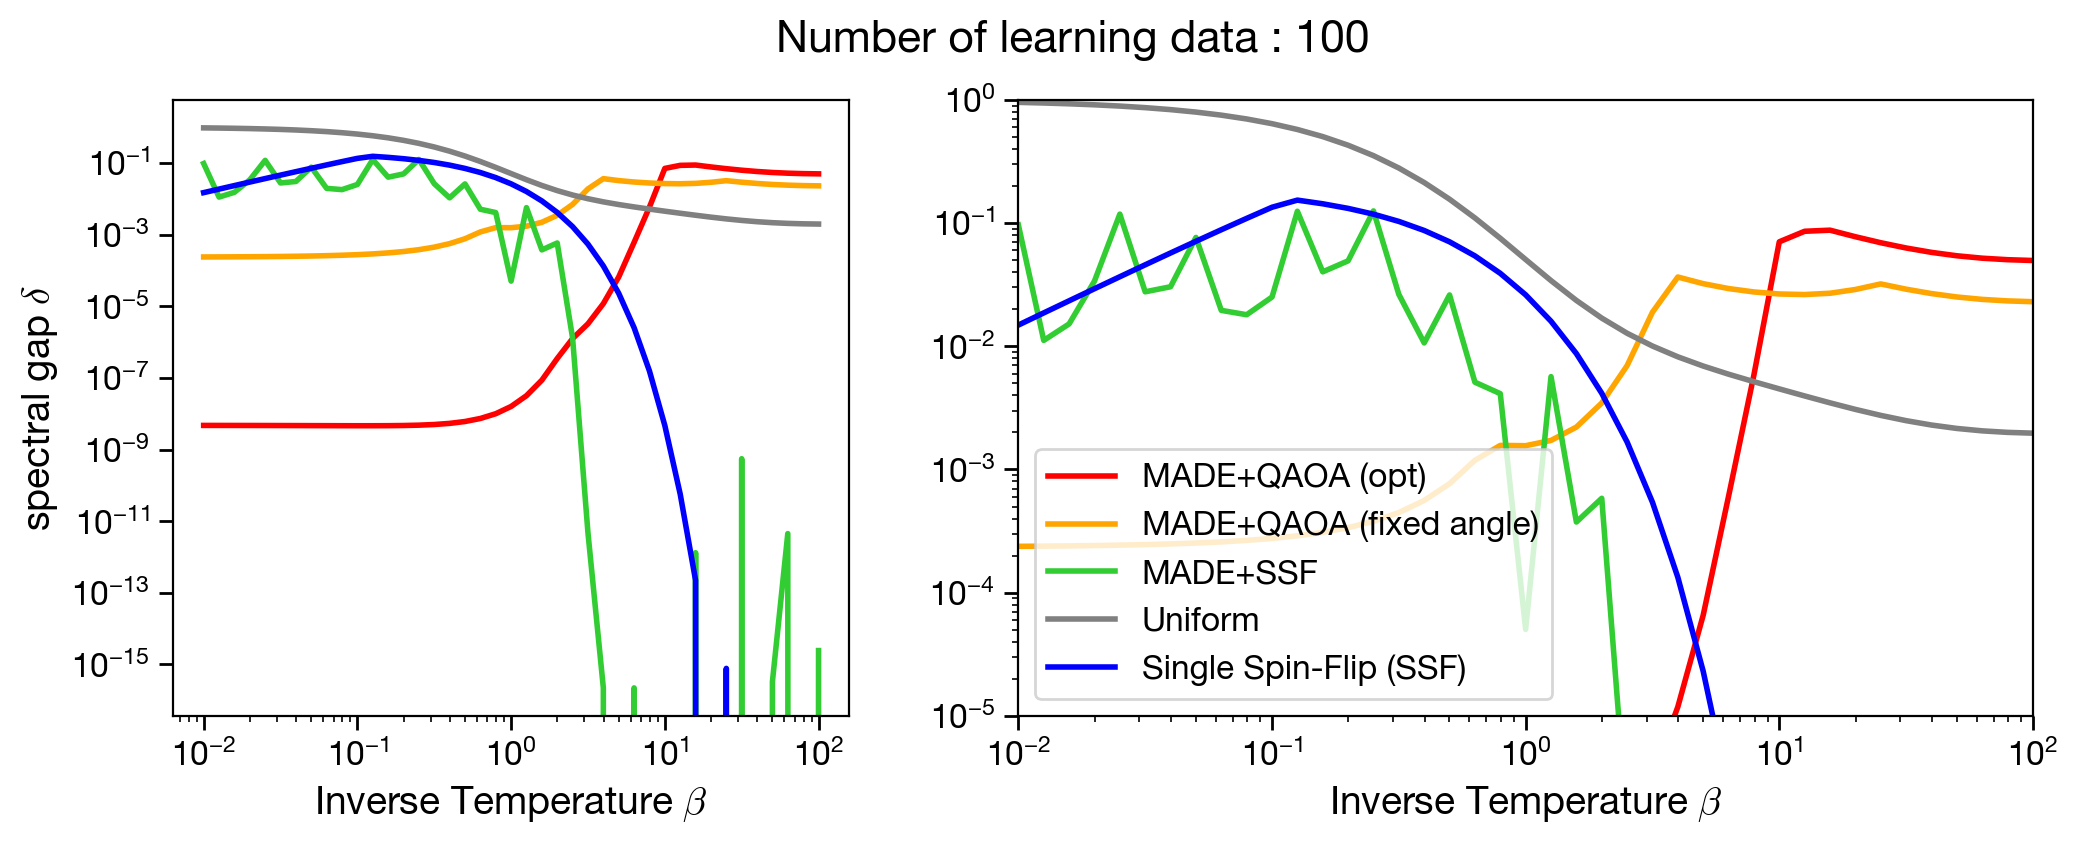

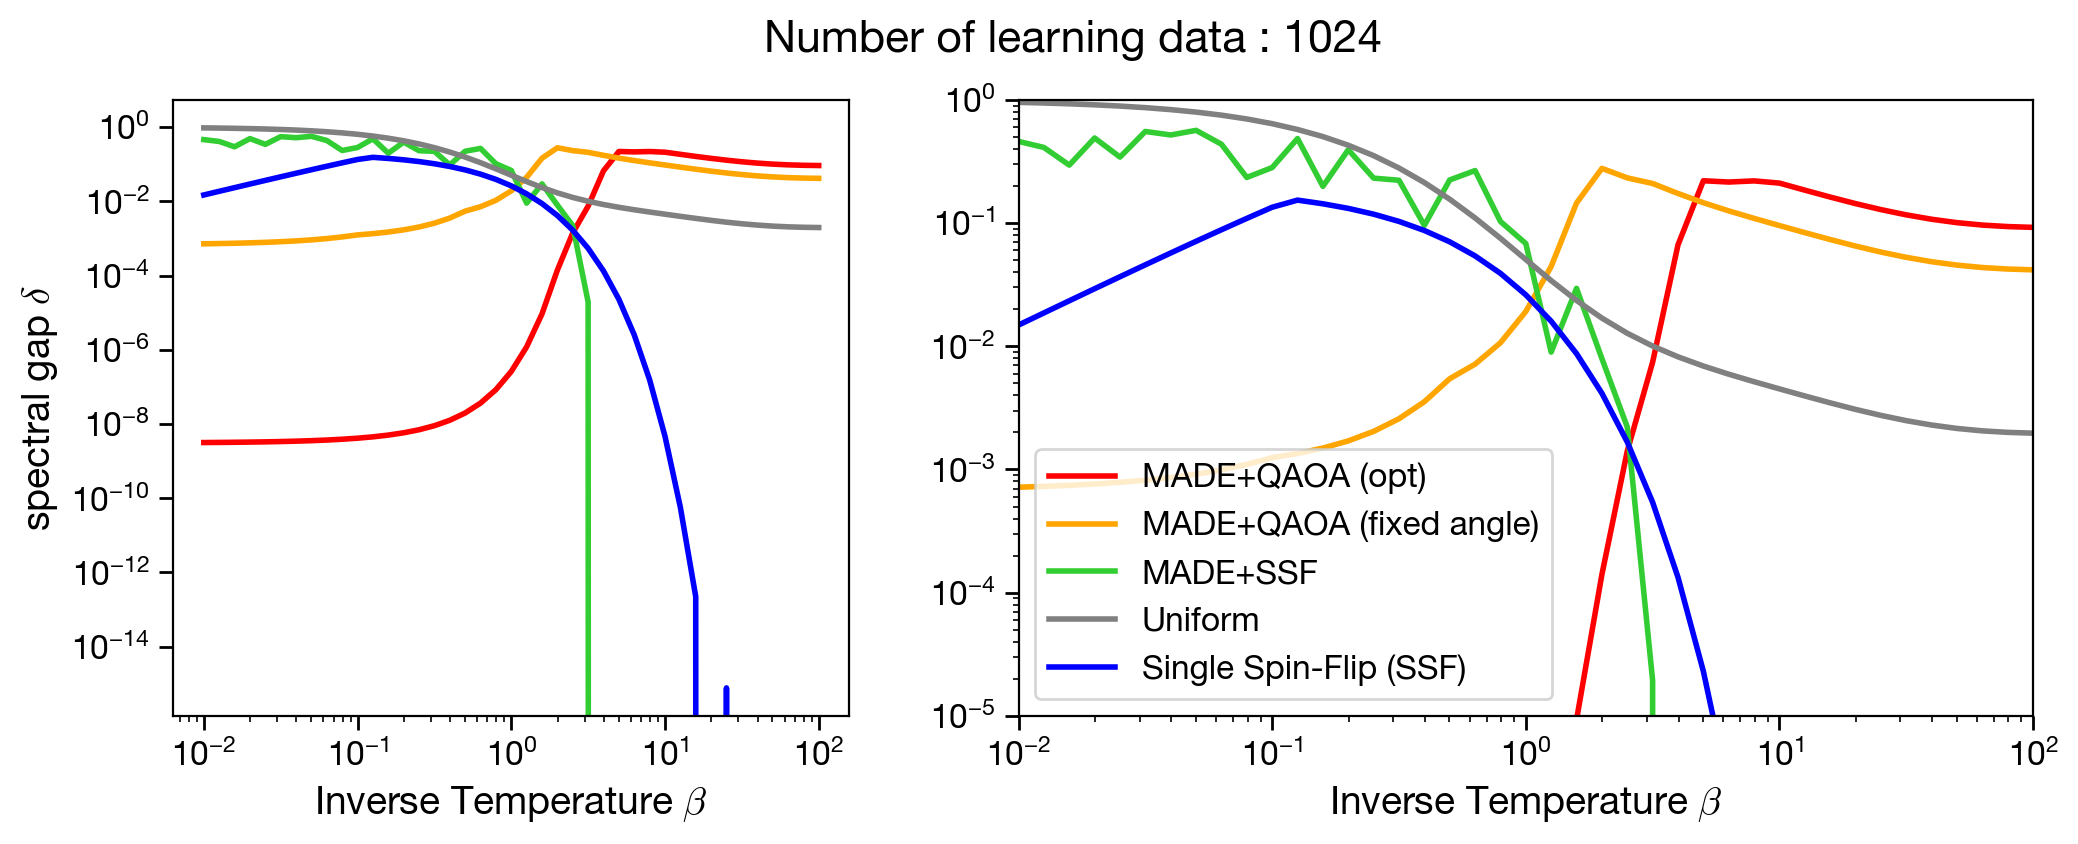

In [10]:
for i in range(len(n_data_list)):
	fig1, ax1 = plt.subplots(1,2, width_ratios=[2,3], figsize=(12,4), dpi=200)

	ax1[0].plot(beta_list, opt_qaoa_made_gap_list[i], linewidth=2, color='red', label='MADE+QAOA (opt)')
	ax1[0].plot(beta_list, fix_qaoa_made_gap_list[i], linewidth=2, color='orange', label='MADE+QAOA (fixed angle)')
	ax1[0].plot(beta_list, ssf_made_gap_list[i], linewidth=2, color='limegreen', label='MADE+SSF')
	ax1[0].plot(beta_list, uni_gap_list[i], linewidth=2, color='grey', label='Uniform')
	ax1[0].plot(beta_list, ssf_gap_list[i], linewidth=2, color='blue', label='Single Spin-Flip (SSF)')

	ax1[0].set_xscale("log")
	ax1[0].set_yscale("log")
	ax1[0].set_xlabel(r'Inverse Temperature $\beta$', {"fontsize": 14})
	ax1[0].set_ylabel(r'spectral gap $\delta$', {"fontsize": 14})
	ax1[0].tick_params(width=1.0, labelsize=12, length=5)

	ax1[1].plot(beta_list, opt_qaoa_made_gap_list[i], linewidth=2, color='red', label='MADE+QAOA (opt)')
	ax1[1].plot(beta_list, fix_qaoa_made_gap_list[i], linewidth=2, color='orange', label='MADE+QAOA (fixed angle)')
	ax1[1].plot(beta_list, ssf_made_gap_list[i], linewidth=2, color='limegreen', label='MADE+SSF')
	ax1[1].plot(beta_list, uni_gap_list[i], linewidth=2, color='grey', label='Uniform')
	ax1[1].plot(beta_list, ssf_gap_list[i], linewidth=2, color='blue', label='Single Spin-Flip (SSF)')

	ax1[1].set_xscale("log")
	ax1[1].set_yscale("log")
	ax1[1].set_xlim(1e-2, 1e2)
	ax1[1].set_ylim(1e-5, 1)
	ax1[1].set_xlabel(r'Inverse Temperature $\beta$', {"fontsize": 14})
	ax1[1].tick_params(width=1.0, labelsize=12, length=5)
	ax1[1].legend(fontsize=12, loc='lower left')
	
	fig1.suptitle('Number of learning data : {0}'.format(n_data_list[i]), fontsize=16, fontweight="bold")

### MADE出力分布

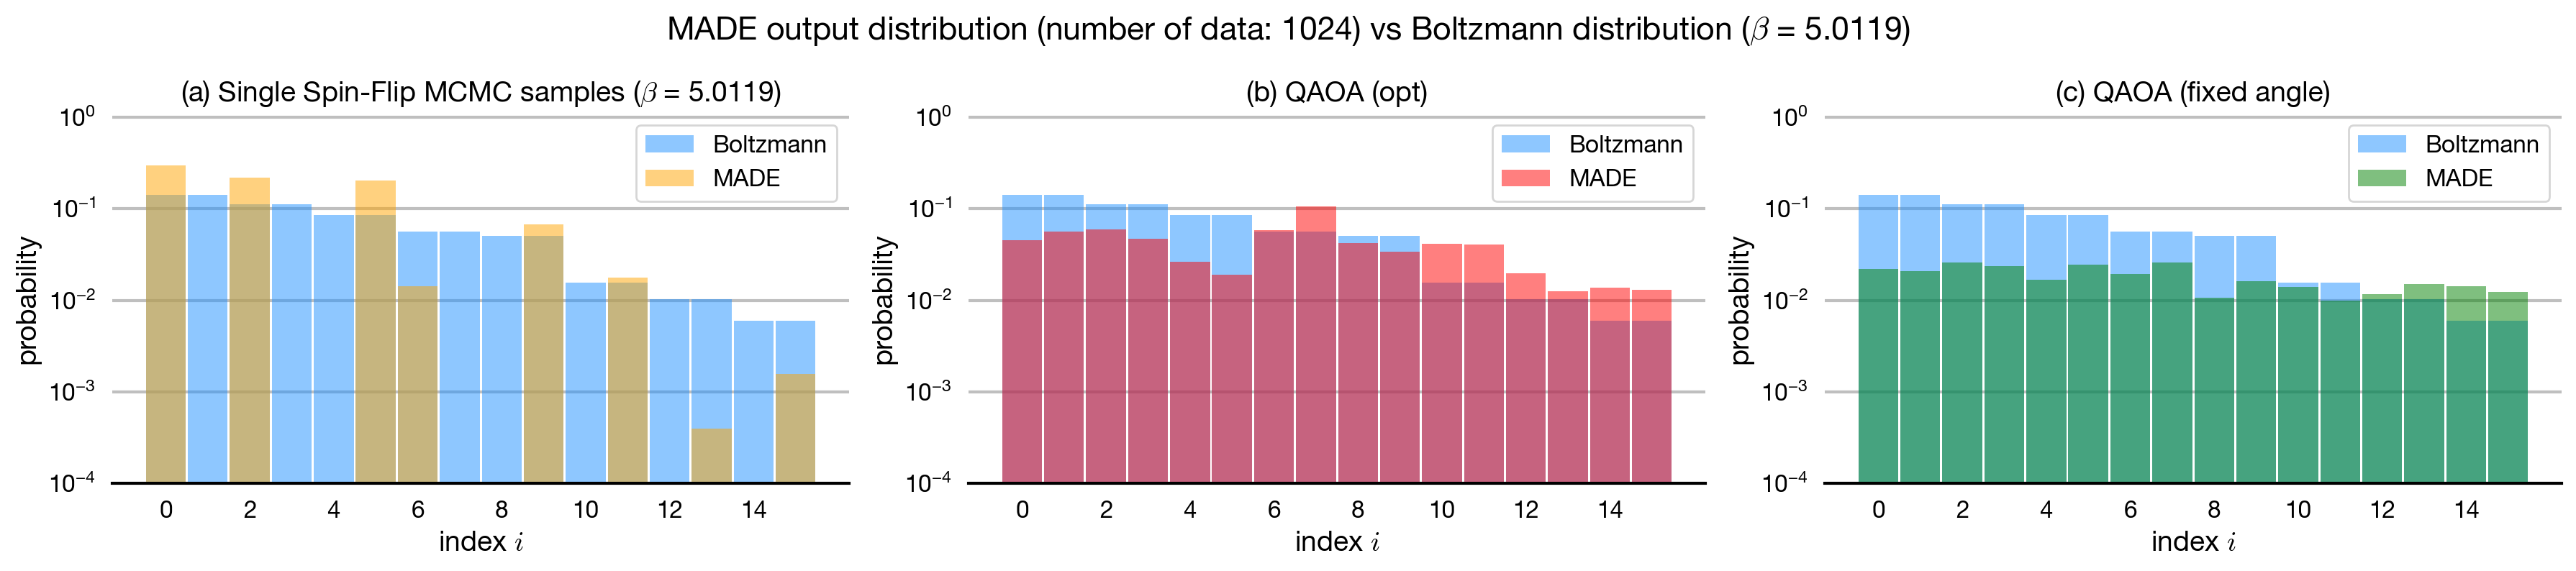

In [17]:
# setting
beta_index = 27
n_data_index = 4

# calculation
min_energy = ising.min_exact_spin_energy(instance)
boltzmann_prob = ising.spin_boltzmann_distribution(instance, beta_list[beta_index])
boltzmann_prob_sort = np.sort(boltzmann_prob)[::-1]

# plot
n_top = 16
sort_idx = np.argsort(boltzmann_prob)[::-1]

fig2, ax2 = plt.subplots(1,3, figsize=(18,4), dpi=200)
fig2.suptitle(r'MADE output distribution (number of data: {1}) vs Boltzmann distribution ($\beta$ = {0:.4f})'.format(beta_list[beta_index], n_data_list[n_data_index]), fontsize=16)

# MADE+SFF
ax2[0].spines["top"].set_linewidth(0)
ax2[0].spines["left"].set_linewidth(0)
ax2[0].spines["bottom"].set_linewidth(1.5)
ax2[0].spines["right"].set_linewidth(0)

ax2[0].bar(np.arange(n_top), boltzmann_prob_sort[0:n_top], width=0.95, color='dodgerblue', alpha=0.5, label="Boltzmann")
ax2[0].bar(np.arange(n_top), ssf_made_pred_list[n_data_index, beta_index, sort_idx[0:n_top]], width=0.95, color='orange', alpha=0.5, label="MADE")
ax2[0].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5)
ax2[0].set_axisbelow(True) #gridを背面にする
ax2[0].set_xlabel(r'index $i$', fontsize=14)
ax2[0].set_ylabel("probability", fontsize=14)
ax2[0].set_xticks(np.arange(0, n_top, 2))
ax2[0].set_yscale('log')
ax2[0].set_ylim(1e-4, 1.1e0)
ax2[0].tick_params(width=0, labelsize=12, length=5)
ax2[0].tick_params(axis="y", which='minor', width=0.0)
ax2[0].set_title(r'(a) Single Spin-Flip MCMC samples ($\beta$ = {0:.4f})'.format(beta_list[beta_index]), fontsize=14)
ax2[0].legend(fontsize=12)

# MADE+QAOA(opt)
ax2[1].spines["top"].set_linewidth(0)
ax2[1].spines["left"].set_linewidth(0)
ax2[1].spines["bottom"].set_linewidth(1.5)
ax2[1].spines["right"].set_linewidth(0)

ax2[1].bar(np.arange(n_top), boltzmann_prob_sort[0:n_top], width=0.95, color='dodgerblue', alpha=0.5, label="Boltzmann")
ax2[1].bar(np.arange(n_top), opt_qaoa_made_pred_list[n_data_index, sort_idx[0:n_top]], width=0.95, color='red', alpha=0.5, label="MADE")
ax2[1].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5)
ax2[1].set_axisbelow(True) #gridを背面にする
ax2[1].set_xlabel(r'index $i$', fontsize=14)
ax2[1].set_ylabel("probability", fontsize=14)
ax2[1].set_xticks(np.arange(0, n_top, 2))
ax2[1].set_yscale('log')
ax2[1].set_ylim(1e-4, 1.1e0)
ax2[1].tick_params(width=0, labelsize=12, length=5)
ax2[1].tick_params(axis="y", which='minor', width=0.0)
ax2[1].set_title("(b) QAOA (opt)", fontsize=14)
ax2[1].legend(fontsize=12)

# MADE+QAOA(fixed angle)
ax2[2].spines["top"].set_linewidth(0)
ax2[2].spines["left"].set_linewidth(0)
ax2[2].spines["bottom"].set_linewidth(1.5)
ax2[2].spines["right"].set_linewidth(0)

ax2[2].bar(np.arange(n_top), boltzmann_prob_sort[0:n_top], width=0.95, color='dodgerblue', alpha=0.5, label="Boltzmann")
ax2[2].bar(np.arange(n_top), fix_qaoa_made_pred_list[n_data_index, sort_idx[0:n_top]], width=0.95, color='green', alpha=0.5, label="MADE")
ax2[2].grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5)
ax2[2].set_axisbelow(True) #gridを背面にする
ax2[2].set_xlabel(r'index $i$', fontsize=14)
ax2[2].set_ylabel("probability", fontsize=14)
ax2[2].set_xticks(np.arange(0, n_top, 2))
ax2[2].set_yscale('log')
ax2[2].set_ylim(1e-4, 1.1e0)
ax2[2].tick_params(width=0, labelsize=12, length=5)
ax2[2].tick_params(axis="y", which='minor', width=0.0)
ax2[2].set_title("(c) QAOA (fixed angle)", fontsize=14)
ax2[2].legend(fontsize=12)

plt.tight_layout()

### SSF教師データの分布

[0 0 0 ... 0 0 0]


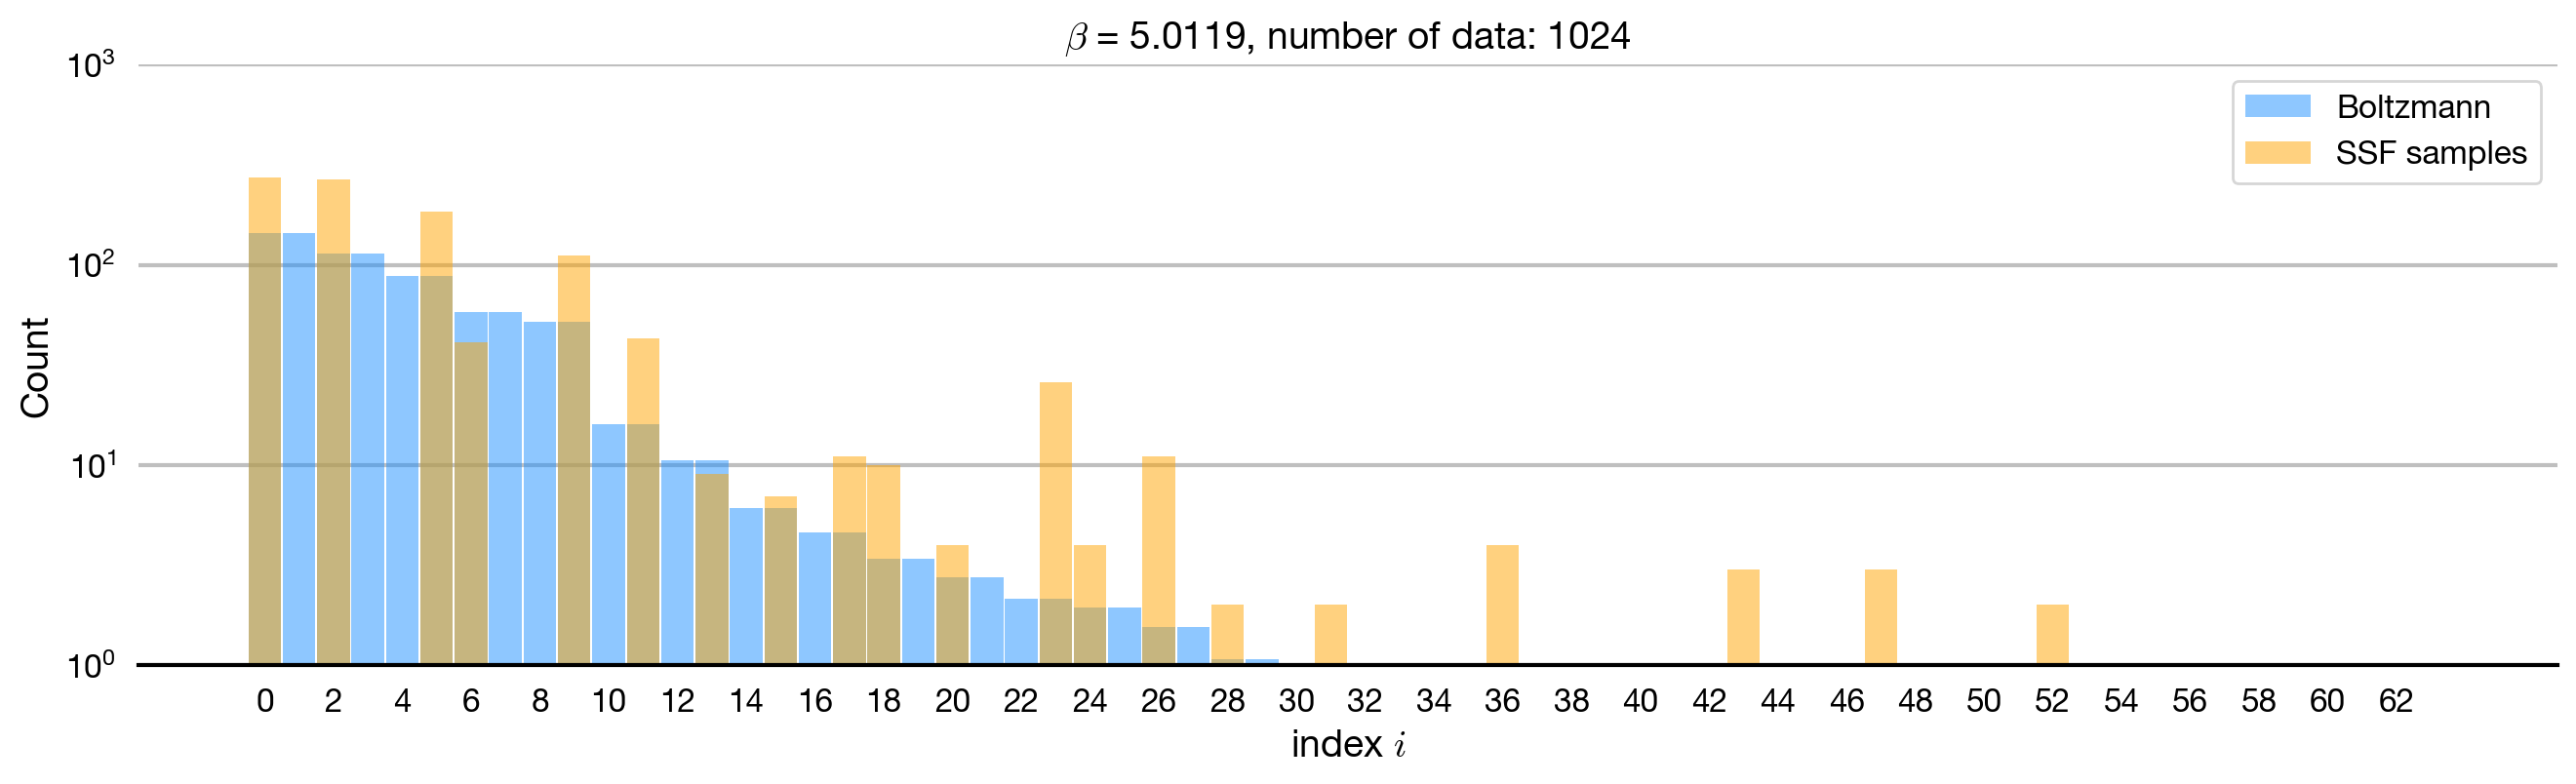

In [18]:
# caluculation
beta_index = 27
n_data_index = 4
ssf_data_id = np.array([qaoa.binary_to_number(ssf_data[beta_index, i]) for i in range(n_data_list[n_data_index])])
ssf_hist = np.histogram(ssf_data_id, np.arange(2**n_spin))[0]

min_energy = ising.min_exact_spin_energy(instance)
boltzmann_prob = ising.spin_boltzmann_distribution(instance, beta_list[beta_index])
boltzmann_prob_sort = np.sort(boltzmann_prob)[::-1]

print(ssf_hist)

# plot
n_top = 64
sort_idx = np.argsort(boltzmann_prob)[::-1]

fig3, ax3 = plt.subplots(figsize=(16,4), dpi=200)

ax3.spines["top"].set_linewidth(0)
ax3.spines["left"].set_linewidth(0)
ax3.spines["bottom"].set_linewidth(1.5)
ax3.spines["right"].set_linewidth(0)

ax3.bar(np.arange(n_top), (2**n_spin)*boltzmann_prob_sort[0:n_top], width=0.95, color='dodgerblue', alpha=0.5, label="Boltzmann")
ax3.bar(np.arange(n_top), ssf_hist[sort_idx[0:n_top]], width=0.95, color='orange', alpha=0.5, label="SSF samples")
ax3.grid(axis='y', color='#BFBFBF', linestyle='-', linewidth=1.5)
ax3.set_axisbelow(True) #gridを背面にする
ax3.set_xlabel(r'index $i$', fontsize=14)
ax3.set_ylabel("Count", fontsize=14)
ax3.set_xticks(np.arange(0, n_top, 2))
ax3.set_yscale('log')
ax3.set_ylim(1e0, 1e3)
ax3.tick_params(width=0, labelsize=12, length=5)
ax3.tick_params(axis="y", which='minor', width=0.0)
ax3.set_title(r'$\beta$ = {0:.4f}, number of data: {1}'.format(beta_list[beta_index], n_data_list[n_data_index]), fontsize=14)
ax3.legend(fontsize=12)